In [3]:
import pandas
import datetime

In [4]:
stock_df = pandas.read_csv('TSLA.csv', index_col='Date', parse_dates=True)
stock_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,19.000000,25.000000,17.540001,23.889999,23.889999,18766300
2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100
2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800
2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800
2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900
...,...,...,...,...,...,...
2020-01-28,568.489990,576.809998,558.080017,566.900024,566.900024,11788500
2020-01-29,575.690002,589.799988,567.429993,580.989990,580.989990,17801500
2020-01-30,632.419983,650.880005,618.000000,640.809998,640.809998,29005700


In [5]:
closings = stock_df['Close']
closings

Date
2010-06-29     23.889999
2010-06-30     23.830000
2010-07-01     21.959999
2010-07-02     19.200001
2010-07-06     16.110001
                 ...    
2020-01-28    566.900024
2020-01-29    580.989990
2020-01-30    640.809998
2020-01-31    650.570007
2020-02-03    780.000000
Name: Close, Length: 2416, dtype: float64

In [7]:
mean = sum(closings) / len(closings)
mean

186.40365078187054

In [469]:
closings.shape

(2416,)

In [470]:
import matplotlib.pyplot as plt

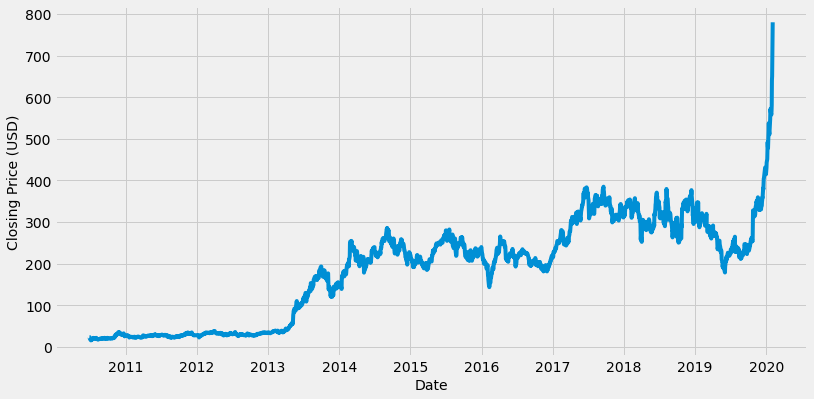

In [471]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,6))
plt.plot(closings)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price (USD)', fontsize=14)
plt.show()

In [472]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [473]:
#compresses the closings prices to the range 0 to 1
scaler = MinMaxScaler(feature_range = (0,1))

scaled_closings = scaler.fit_transform(np.array(closings).reshape(-1,1))
scaled_closings

array([[0.01058623],
       [0.01050772],
       [0.00806072],
       ...,
       [0.81786181],
       [0.83063335],
       [1.        ]])

In [547]:
#using 75% of the data to train the model and 25% to test the model
train_size = int(len(scaled_closings) * .75)

test_size = len(scaled_closings) - train_size
train_data = scaled_closings[0:train_size,:]
test_data = scaled_closings[train_size:, :]

1812

In [475]:
def create_data(data, time_interval):
    X_data = []
    y_data = []
    for day in range(len(data)-time_interval-1):
        interval = data[day : (day + time_interval), 0]
        output_day = data[day + time_interval]
        
        #X_data holds 10 days and y_data holds the 11th day of each interval
        X_data.append(interval)
        y_data.append(output_day)
        
    return numpy.array(X_data), numpy.array(y_data)

In [549]:
#using a 10 day moving average
time_interval = 10

X_train, y_train = create_data(train_data, time_interval)
X_test, y_test = create_data(test_data, time_interval)

1812

In [477]:
#reshapes the arrays to fit a numpy array
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [478]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [479]:
model = Sequential()
model.add(LSTM(64, return_sequences = True, input_shape = (time_interval, 1)))
model.add(LSTM(64, return_sequences = True))
model.add(LSTM(64))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [480]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 10, 64)            16896     
_________________________________________________________________
lstm_37 (LSTM)               (None, 10, 64)            33024     
_________________________________________________________________
lstm_38 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 83,009
Trainable params: 83,009
Non-trainable params: 0
_________________________________________________________________


In [481]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 1, batch_size = 64)

29/29 [==============================] - 2s 64ms/step - loss: 0.0098 - val_loss: 0.0012


In [482]:
predict_train = model.predict(X_train)
predict_test = model.predict(X_test)

In [483]:
#convert the numbers from the compressed values back to regular prices
predict_train = scaler.inverse_transform(predict_train)
predict_test = scaler.inverse_transform(predict_test)
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [484]:
predict_test_list = []
y_test_list = []
predict_train_list = []
y_train_list = []

#creates arrays for just the values in each
for i in predict_test:
    predict_test_list.append(i[0])
for i in y_test:
    y_test_list.append(i[0])
for i in predict_train:
    predict_train_list.append(i[0])
for i in y_train:
    y_train_list.append(i[0])

In [485]:
from sklearn.metrics import mean_squared_error
import math

In [486]:
#calculates the error in the training set
math.sqrt(mean_squared_error(y_train_list, predict_train_list))

12.658718660988649

In [499]:
#calculates the error in the test set
math.sqrt(mean_squared_error(y_test_list, predict_test_list))

26.605868717381156

In [550]:
stock_df2 = pandas.read_csv('TSLA.csv')
closings2 = stock_df2['Close']

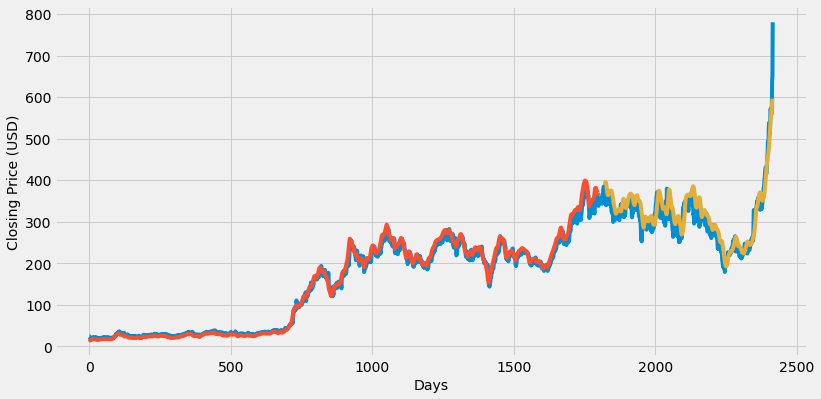

In [569]:
trainPlot = numpy.empty_like(closings)
trainPlot[:] = np.nan
trainPlot[: len(predict_train)] = predict_train_list

testPlot = numpy.empty_like(closings)
testPlot[:] = numpy.nan
testPlot[len(predict_train) + (time_interval * 2) + 1 : len(closings) - 1] = predict_test_list

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,6))
plt.plot(closings2)
plt.plot(trainPlot)
plt.plot(testPlot)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Closing Price (USD)', fontsize=14)
plt.show()
plt.show()

In [629]:
X_input = test_data[len(test_data) - time_interval :].reshape(1,-1)

In [630]:
temp_input = list(X_input)
temp_input = temp_input[0].tolist()
temp_input

[0.6953677204920178,
 0.7246270583616855,
 0.7280816697199686,
 0.7184245053650876,
 0.7095263281863387,
 0.7211463281863386,
 0.7395838654802408,
 0.8178618136613452,
 0.8306333512169589,
 1.0]

In [631]:
from numpy import array
i = 0
output = []
while (i < 30):
    if (len(temp_input) > 10):
        X_input = np.array(temp_input[1:])
        print('{} day input {}'.format(i, X_input))
        X_input.reshape(-1,1)
        X_input = X_input.reshape(1, time_interval, 1)
        prediction = model.predict(X_input, verbose=0)
        print('{} day output {}'.format(i, prediction))
        temp_input.extend(prediction[0].tolist())
        temp_input = temp_input[1:]
        output.extend(prediction.tolist())
        i = i + 1
    else:
        X_input = X_input.reshape(1, time_interval, 1)
        prediction = model.predict(X_input, verbose = 0)
        print(prediction)
        temp_input.extend(prediction[0].tolist())
        print(len(temp_input))
        output.extend(prediction.tolist())
        i = i + 1

print(output)


[[0.7974927]]
11
1 day input [0.72462706 0.72808167 0.71842451 0.70952633 0.72114633 0.73958387
 0.81786181 0.83063335 1.         0.79749268]
1 day output [[0.8157411]]
2 day input [0.72808167 0.71842451 0.70952633 0.72114633 0.73958387 0.81786181
 0.83063335 1.         0.79749268 0.81574112]
2 day output [[0.8318747]]
3 day input [0.71842451 0.70952633 0.72114633 0.73958387 0.81786181 0.83063335
 1.         0.79749268 0.81574112 0.83187473]
3 day output [[0.84906644]]
4 day input [0.70952633 0.72114633 0.73958387 0.81786181 0.83063335 1.
 0.79749268 0.81574112 0.83187473 0.84906644]
4 day output [[0.86874706]]
5 day input [0.72114633 0.73958387 0.81786181 0.83063335 1.         0.79749268
 0.81574112 0.83187473 0.84906644 0.86874706]
5 day output [[0.89045644]]
6 day input [0.73958387 0.81786181 0.83063335 1.         0.79749268 0.81574112
 0.83187473 0.84906644 0.86874706 0.89045644]
6 day output [[0.911071]]
7 day input [0.81786181 0.83063335 1.         0.79749268 0.81574112 0.8318747

In [633]:
day_new = np.arange(1, 11)
day_pred = np.arange(11, 41)

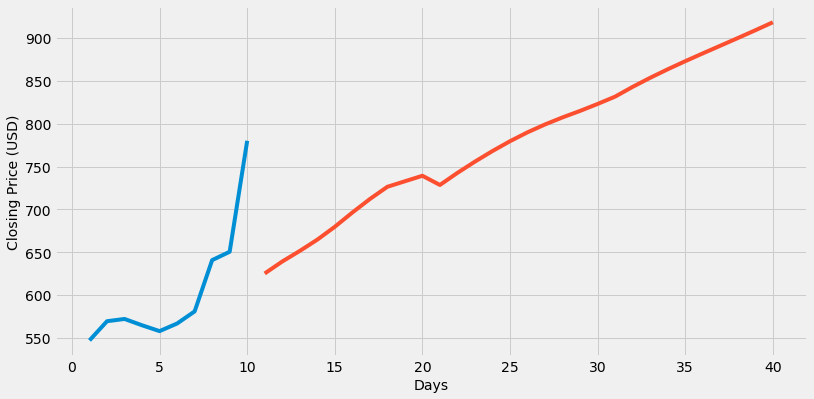

In [644]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,6))
plt.plot(day_new, closings[len(closings) - time_interval :])
plt.plot(day_pred, scaler.inverse_transform(output))
plt.xlabel('Days', fontsize=14)
plt.ylabel('Closing Price (USD)', fontsize=14)
plt.show()
plt.show()